# Photon Cross Section

## Useful costants

In [1]:
from scipy.integrate import quad
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#Planck Constant(ergs)
h = 6.62606957e-27

#Planck Constant(eVs)
h_eV = 4.135667662e-15

#Boltzmann Constant(erg/K)
k = 1.3806485279e-16

#frequence_0
mu0 = 1e0/h

#Gravitional constant(cm^3/g/s)
G = 6.67408e-8

#Mass of a Hydrogen atom(g)
mH = 1.67357e-24

#Mass of a Helium atom(g)
mHe = 1.67357e-24*4.0026022/1.00794

nH = 1e5
nHe = 1e4

xe = 0


#Initial conditions
T = 1.6e2 #K
J21 = 0.1

In [2]:
from Spectrum_to_Ionization import Spec #Guangshuai's data
import Spectrum_to_Ionization as spi

## Calculating the cross sections of HI and HeI

In [3]:
class atom:
    def __init__(self, name, Eth, Emax, E0, sigma0, ya, P, yw, y0, y1):
        self.name = name
        self.Eth, self.Emax, self.E0 = Eth, Emax, E0
        self.sigma0, self.P = sigma0, P
        self.ya, self.yw, self.y0, self.y1 = ya, yw, y0, y1
        if (name == 'H'):
            self.aa, self.bb, self.cc = 0.3908, 0.4092, 1.7592
        elif (name == 'He'):
            self.aa, self.bb, self.cc = 0.0554, 0.4614, 1.666
        else:
            self.aa, self.bb, self.cc = 0, 0, 0

    def cross(self, E):
        x = E/self.E0-self.y0
        y = np.sqrt(x**2+self.y1**2)
        D = (x-1)**2+self.yw**2
        B = np.power(y, 0.5*self.P-5.5)
        C = np.power(1+np.sqrt(y/self.ya),-self.P)
        return(D*B*C*self.sigma0*1e-18)

    def draw(self):
        E = np.linspace(self.Eth, self.Emax, 10000)
        sigma = self.cross(E)
        plt.xscale('log')
        plt.yscale('log')
        plt.plot(E, sigma, label=self.name)
        plt.xlabel("E(eV)",fontsize=13)
        plt.ylabel("$\sigma$(cm$^2$)",fontsize=13)
        plt.legend()

    def min(self):
        return self.Eth

    def max(self):
        return self.Emax

    def getabc(self):
        return self.aa, self.bb, self.cc

In [4]:
def main():
    H = atom('H', 1.360E+1, 5.000E+04, 4.298E-01, 5.475E+04, 3.288E+01, 2.963E+00, 0.000E+00, 0.000E+00, 0.000E+00)
    He = atom('He', 2.459E+1, 5.000E+04, 1.361E+01, 9.492E+02, 1.469E+00, 3.188E+00, 2.039E+00, 4.434E-01, 2.136E+00)
    C = atom('C',1.126E+01, 2.910E+02, 2.144E+00, 5.027E+02, 6.216E+01, 5.101E+00, 9.157E-02, 1.133E+00, 1.607E+00)
    O = atom('O',1.362E+01, 5.380E+02, 1.240E+00, 1.745E+03, 3.784E+00, 1.764E+01, 7.589E-02, 8.698E+00, 1.271E-01)
    N = atom('N',1.453E+01, 4.048E+02, 4.034E+00, 8.235E+02, 8.033E+01, 3.928E+00, 9.097E-02, 8.598E-01, 2.325E+00)
    Mg = atom('Mg',7.646E+00, 5.490E+01, 1.197E+01, 1.372E+08, 2.228E-01, 1.574E+01, 2.805E-01, 0.000E+00, 0.000E+00)
    #H.draw()
    #He.draw()
    #C.draw()
    #O.draw()
    #plt.show()
    print(O.cross(500)/H.cross(500))
    print(C.cross(500)/H.cross(500))
    print(O.cross(1000)/H.cross(1000))
    print(C.cross(1000)/H.cross(1000))
    print(N.cross(1000)/H.cross(1000))
    print(Mg.cross(1000)/H.cross(1000)) #Ratios

In [5]:
main()

302.0176806388171
103.06672815494315
411.3498814055944
154.6646755115795
282.8722370574143
7.36010384707904


In [6]:
H = atom('H', 1.360E+01, 5.000E+04, 4.298E-01, 5.475E+04, 3.288E+01, 2.963E+00, 0.000E+00, 0.000E+00, 0.000E+00)
He = atom('He', 2.459E+01, 5.000E+04, 1.361E+01, 9.492E+02, 1.469E+00, 3.188E+00, 2.039E+00, 4.434E-01, 2.136E+00)

## Calculating the X-rays ionization rates of HI and HeII
> Lafif+ 2015

- The primary ionization rate

$$
\zeta_p^i=\frac{4\pi}{h}\int_{E_{min}}^{E_{max}}\frac{J(E)}{E}e^{-\tau(E)}\sigma^i(E)\text{d}E\\
J(E)=J_{X,21}\left( \frac{E}{1\text{keV}}\right) ^{-1.5}\times10^{-21}\text{ erg cm}^{−2}\text{ s}^{-1}\text{ Hz}^{-1} \text{ sr}^{-1}
$$

In [7]:
# Flux
def F_E(E): #E in eV, F_E in s^-1cm^-2
    return(4*np.pi/h*1e-21*np.power(E/1000.0,-1.5))

# Primary Ionization

def Ion_p(H, He, A, spec = None, nH = 1e5, nHe = 1e4):
    if spec == None:
        val1, err1 = quad(lambda epsilon:F_E(epsilon)/epsilon*np.exp(-Tau(epsilon, H, He, nH, nHe))*A.cross(epsilon), 2000, 10000)
        return(val1)
    y = np.array([])
    for i in range(len(spec.E_eV)):
        y = np.append(y, spec.Fnu_abs[i]/h/spec.E_eV[i]*np.exp(-Tau(spec.E_eV[i], H, He, nH, nHe))*A.cross(spec.E_eV[i]))
    return(inte(spec.E_eV, y))

- Optical depth $\tau$ is determined by the size of the cloud as well as the abundance of each species

$$
\tau(E)=\sum_{i=\mathrm H,\mathrm He}N_i\sigma^i=\frac{\lambda_J}{2}\sum_{i=\mathrm H,\mathrm He}n_i\sigma^i
$$

- To estimate the size we take Jeans length

$$
\lambda_J=\sqrt{\frac{\pi kT}{G\rho \mu m_p}}
$$

where the mean molecular mass
$$
\mu=\frac{1.00794n_H+4.0026022n_{He}}{n_H+n_{He}}
$$

In [34]:
# Jeans Length (Consider only H/He)
def Jeans(nH, nHe):
    rhogas = nH*mH+nHe*mHe
    mu = (4.0026022*nHe+1.00794*nH)/(nH+nHe)
    jeans_length = np.sqrt(np.pi*k*T/rhogas/mH/G/mu)
    return(jeans_length)

# Optical Depth
def Tau(E, H, He, nH = 1e5, nHe = 1e4):
    lambda_j = Jeans(nH, nHe)
    NH, NHe = nH*lambda_j, nHe*lambda_j
    tau = H.cross(E)*NH + He.cross(E)*NHe
    return(tau/2.0)

# Column Density
def Col(nH, nHe):
    lambda_j = Jeans(nH, nHe)
    col = (nH+nHe)*lambda_j
    return(col/2.0)

- $\sigma^i$ comes from Verner $\&$ Ferland (1996)

- $\langle\phi^j\rangle​$ is much more complex. For $E>100​$eV and H, He mixture

$$
\phi^H(E,x_e)=\left( \frac{E}{13.6\text{eV}}-1\right)0.3908(1-x_e^{0.4092})^{1.7592}\\
\phi^He(E,x_e)=\left( \frac{E}{24.6\text{eV}}-1\right)0.0554(1-x_e^{0.4614})^{1.666} 
$$

where $x_e​$ is the electron fraction
$$
\langle\phi^i\rangle=\frac{\int J(E)\phi^i(E,x_e)\text{d}E}{\int J(E)\text{d}E}
$$

In [9]:
def phi(E, A):
    aa, bb, cc = A.getabc()
    ph = (E/A.min()-1)*aa*np.power(1-np.power(xe, bb), cc)
    return ph

def phi_bar(A):
    J_Phi, err1 = quad(lambda epsilon:J21*1e-21*np.power(epsilon/1000.0,-1.5)*phi(epsilon, A), 2000, 10000)
    J, err2 = quad(lambda epsilon:J21*1e-21*np.power(epsilon/1000.0,-1.5), 2000, 10000)
    return(J_Phi/J)

def phi_b(A):
    aa, bb, cc = A.getabc()
    if A.name == 'H':
        return 327.832286034056e0*aa*np.power(1-np.power(xe, bb), cc)
    elif A.name == 'He':
        return 180.793458763612e0*aa*np.power(1-np.power(xe, bb), cc)
    else:
        return 0

def Ion_x(n1, n2, H, He, A, B, spec = None): #the method offered in Latif 2015
    Ip = Ion_p(H, He, A, spec)
    zeta_2 = (Ip + n2/n1*Ion_p(H, He, B, spec))*phi_bar(A)
    return(Ip + zeta_2)

def Ion_xx(n1, n2, H, He, A, B, spec = None): #what krome is actually using(simplified phi_b)
    Ip = Ion_p(H, He, A, spec)
    zeta_2 = (Ip + n2/n1*Ion_p(H, He, B, spec))*phi_b(A)
    return(Ip + zeta_2)

def Ion_xxx(n1, n2, H, He, A, B, spec = None):
    Ip = Ion_p(H, He, A, spec)
    I21,err1 = quad(lambda epsilon:F_E(epsilon)*np.exp(-Tau(epsilon, H, He))/epsilon*B.cross(epsilon)*phi(epsilon,A), 2000, 10000)
    I22,err2 = quad(lambda epsilon:F_E(epsilon)*np.exp(-Tau(epsilon, H, He))/epsilon*A.cross(epsilon)*phi(epsilon,A), 2000, 10000)
    print(I22/Ion_p(H, He, A, spec)/phi_bar(A))
    print(I21/Ion_p(H, He, B, spec)/phi_bar(A))
    print()
    return(Ip+n2/n1*I21+I22)

- The total X-ray ionization rate for certain species $i$

$$
\zeta_x^i=\zeta_p^i+\sum_{j=H,He}\frac{n_j}{n_i}\zeta_p^j\langle\phi^j\rangle
$$

where $n_j​$ is the number density

In [10]:
def test(H, He, spec = None):
    print(H.name, np.log10(Ion_p(H, He, H, spec)), np.log10(Ion_x(nH, nHe, H, He, H, He, spec)))
    print(He.name, np.log10(Ion_p(H, He, He, spec)), np.log10(Ion_x(nHe, nH, H, He, He, H, spec)))
    print()
    #print(Ion_x(nH, nHe, H, He, H, He, spec)/Ion_p(H, He, H, spec), np.log10(Ion_x(nH, nHe, H, He, H, He, spec)))
    #print(Ion_x(nHe, nH, H, He, He, H, spec)/Ion_p(H, He, H, spec), np.log10(Ion_x(nHe, nH, H, He, He, H, spec)))
    #print()
    #print(Ion_xx(nH, nHe, H, He, H, He), np.log10(Ion_xx(nH, nHe, H, He, H, He)))
    #print(Ion_xx(nHe, nH, H, He, He, H), np.log10(Ion_xx(nHe, nH, H, He, He, H)))
    #print()
    #print(Ion_xxx(nH, nHe, H, He, H, He), np.log10(Ion_xxx(nH, nHe, H, He, H, He)))
    #print(Ion_xxx(nHe, nH, H, He, He, H), np.log10(Ion_xxx(nHe, nH, H, He, He, H)))

## Draw the flux-energy diagram

In [11]:
def draw_flux(H, He):
    E = np.linspace(100, 5.000E+06, 100000)
    T = np.exp(-Tau(E, H, He))
    J0 = J21*1e-21*np.power(E/1000.0,-1.5)
    Jx = J0*T

    fx = quad(lambda epsilon:J21*1e-21*np.power(epsilon/1000.0,-1.5)*4*np.pi/((h_eV)), 2000, 1000000)[0]
    fy = quad(lambda epsilon:J21*1e-21*np.power(epsilon/1000.0,-1.5)*np.exp(-Tau(epsilon, H, He))*4*np.pi/((h_eV)), 2000, 1000000)[0]
    print(fx, fy)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.loglog(E, J0, label='$J_0$')
    plt.loglog(E, Jx, label='$J_H$')
    plt.xlabel("E(eV)",fontsize=13)
    plt.ylabel("$J$(erg/cm2/s/Hz)",fontsize=13)
    plt.xlim([1e2,1e6])
    plt.ylim([1e-30,1e-15])
    #plt.legend()
    plt.show()
    J1 = J0*T*H.cross(E)
    J2 = J0*T*He.cross(E)
    #plt.ylim([5e-6,1e-3])
    #plt.plot(E, J1, label='$J_H$')
    #plt.plot(E, J2, label='$J_{He}$')
    plt.loglog(E*1.6021773e-12/h, Jx*4*np.pi*E/(4.135667662e-15), label=r'$\nu F_{\nu}$')
    plt.ylim([1e-20,1e0])
    plt.xlabel(r"$\nu$(Hz)",fontsize=13)
    plt.ylabel(r"$\nu F_{\nu}$(erg cm$^{-2}$ s$^{-1}$)",fontsize=13)
    #plt.legend()
    return()

## Calculate the real ionization rate using Guangshuai's data

In [12]:
def inte(x, y, lower = -np.inf, upper = np.inf): #integration with bounds
    s = 0
    ran = np.array([], dtype='int64')
    for i in range(len(x)):
        if x[i] > lower:
            ran = np.append(ran, int(i))
        if x[i] > upper:
            break
    x, y = np.take(x, ran), np.take(y, ran)
    return(np.trapz(y,x)) #integration

### Comparison

- $F_\nu-\nu$ (eV)

In [13]:
def draw_Fnu(i, col1, col2, col3, absorb = True):
    plt.loglog(i.E_eV, i.Fnu, label = i.title(), lw = 0.4, color = col1)
    plt.xlabel(r'$E$(eV)')
    plt.ylabel(r'$F($erg s$^{-1}$ cm $^{-2}$ Hz $^{-1}$)')

    plt.xlim([1e-1,1e6])
    if absorb:
        plt.loglog(i.E_eV, i.Fnu_abs, '--', label = i.title() + ' (absorption)', lw = 0.8, color = col2)
    
    plt.loglog(i.E_eV, i.Fnu_abs*np.exp(-Tau(i.E_eV, H, He)), '-.', label = i.title() + ' (absorption*)', lw = 0.8, color = col3)
    #plt.legend()
    
    plt.xlim([1e2,1e6])
    plt.ylim([1e-30,(i.Fnu).max()*10])
    
def draw_Fnu_model():
    E = np.linspace(100, 5.000E+06, 100000)
    ext = np.exp(-Tau(E, H, He))
    F0 = 4*np.pi*J21*1e-21*np.power(E/1000.0,-1.5)
    Fx = F0*ext
    
    plt.loglog(E, F0, label = r'power law', color = '#006284')
    plt.loglog(E, Fx, '-.', label = r'power law (absorption*)', color = '#81C7D4')
    plt.xlabel("E(eV)", fontsize=13)
    plt.ylabel("$F$(erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)", fontsize=13)

- $\nu F_\nu-\nu$ (Hz)

In [14]:
def draw_nuF(i, col1, col2):
    plt.loglog(i.nu, i.Fnu*i.nu, label = i.title(), lw = 0.4, color = col1)
    plt.loglog(i.nu, i.Fnu_abs*i.nu, '-.', label = i.title(), lw = 0.8, color = col2)
    plt.ylim([1e-8,(i.Fnu*i.nu).max()*10])
    plt.xlim([1e13,1e21])
    #plt.legend()
    
def draw_nuF_model():
    E = np.linspace(100, 5.000E+06, 100000)
    ext = np.exp(-Tau(E, H, He))
    F0 = 4*np.pi*J21*1e-21*np.power(E/1000.0,-1.5)
    Fx = F0*ext
    
    plt.loglog(E*1.6021773e-12/h, Fx*E/(4.135667662e-15), label='power law', color = '#006284')
    plt.xlabel(r"$\nu$(Hz)",fontsize=13)
    plt.ylabel(r"$\nu F_{\nu}$(erg cm$^{-2}$ s$^{-1}$)", fontsize=13)

- $\nu L_\nu-\nu$ (Hz)

In [15]:
def draw_nuL(i, col1, col2):
    plt.loglog(i.nu, i.Lnu*i.nu, lw = 0.4, color = col1)
    plt.loglog(i.nu, i.Fnu_abs*i.nu*4*np.pi*i.distance_cm**2, '-.', label = i.title(), lw = 0.8, color = col2)
    plt.ylim([1e40,(i.Lnu*i.nu).max()*10])
    plt.xlim([1e13,1e21])
    #plt.legend()
    
def draw_nuL_model():
    E = np.linspace(100, 5.000E+06, 100000)
    ext = np.exp(-Tau(E, H, He))
    F0 = 4*np.pi*J21*1e-21*np.power(E/1000.0,-1.5)
    Fx = F0*ext
    
    plt.loglog(E*1.6021773e-12/h, Fx*E/(4.135667662e-15)*4*np.pi*(8*3.08567758e21)**2,  color = '#006284')
    plt.xlabel(r"$\nu$(Hz)",fontsize=13)
    plt.ylabel(r"$\nu L_{\nu}$(erg s$^{-1}$)", fontsize=13)

- Read parameters, pick out certain spectra

In [16]:
def compare(distance, dic):
    ty = '.txt'
    path = '/Users/chang/X-ray-chemistry/Calc_ionization_rate/spectrum data/spectrum/'
    ab, ab_UV = spi.read_abs()
    data_list = spi.readfile(path, ty, distance, ab, ab_UV)
    
    keys = np.array([], dtype = 'int64')
    for i in range(len(data_list)):            
        if data_list[i].info() == dic:
            keys = np.append(int(i), keys)
    if len(keys) == 0:
        print('No such data:')
        print(dic)
        return
    Dat = np.take(data_list, keys).ravel().copy()
    return(Dat)

In [17]:
distance = np.array([1,2,4,8])
dic = {'alpha':0.1, 'beta':100, 'mdot':3}
col1 = ['#fff5eb','#fee6ce','#fdd0a2','#fdae6b','#fd8d3c','#f16913','#d94801','#a63603','#7f2704']
col2 = ['#fff5f0','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#a50f15','#67000d']
col3 = ['#fcfbfd','#efedf5','#dadaeb','#bcbddc','#9e9ac8','#807dba','#6a51a3','#54278f','#3f007d']
col1.reverse()
col2.reverse()
col3.reverse()

In [21]:
Dat = compare(distance, dic)

- Compare the **total fluxes** and **ionization rates** (both primary and secondary)
- $J_{X21}=1$

In [22]:
for i in Dat:
    i.intro()
    print('distance =', i.distance_kpc, 'kpc')
    print('\nTotal Flux:')
    print(inte(i.nu, i.Fnu, lower = 2000*1.6021773e-12/h, upper = 10000*1.6021773e-12/h))
    print(inte(i.nu, i.Fnu_abs, lower = 2000*1.6021773e-12/h, upper = 10000*1.6021773e-12/h))
    print('\nIonization Rate:')
    test(H, He, i)
    print('****************************')
    
print('Standard ionization rate (JX21=0.1) ')
E = np.linspace(1.3e2, 6e8)
print('Total Flux:')
print(quad(lambda epsilon:J21*1e-21*np.power(epsilon/1000.0,-1.5)*4*np.pi/h_eV, 2000, 10000)[0])
print(quad(lambda epsilon:J21*1e-21*np.power(epsilon/1000.0,-1.5)*np.exp(-Tau(epsilon, H, He))*4*np.pi/h_eV, 2000, 10000)[0])
print('\nIonization Rate:')
test(H, He)

************************
alpha =  0.1
beta =  100
mdot =  3.0
************************
distance = 8.0 kpc

Total Flux:
0.0009255320270378775
0.0005673728328528998

Ionization Rate:
H -19.580866187789674 -16.866396304862647
He -18.098468894204974 -16.94253222082845

****************************
************************
alpha =  0.1
beta =  100
mdot =  3.0
************************
distance = 4.0 kpc

Total Flux:
0.00370212810815151
0.0030711306288487795

Ionization Rate:
H -18.295913309187725 -15.584401330484553
He -16.817460054517163 -15.660611377997675

****************************
************************
alpha =  0.1
beta =  100
mdot =  3.0
************************
distance = 2.0 kpc

Total Flux:
0.01480851243260604
0.014518007678969025

Ionization Rate:
H -17.158641802953618 -14.449886486333314
He -15.683872359265688 -14.526166089351198

****************************
************************
alpha =  0.1
beta =  100
mdot =  3.0
************************
distance = 1.0 kpc

Total Flux:

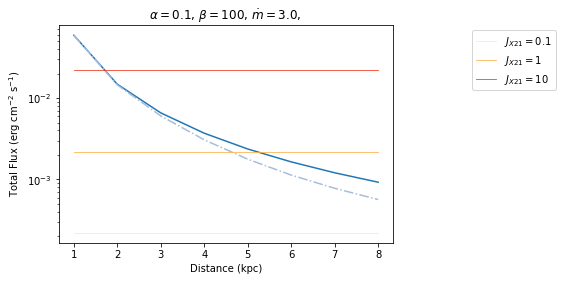

In [23]:
Dat2 = compare(np.arange(8)+1, dic)
ip, ip_abs = np.array([]), np.array([])
for i in Dat2:
    ip = np.append(inte(i.nu, i.Fnu, lower = 2000*1.6021773e-12/h, upper = 10000*1.6021773e-12/h), ip)
    ip_abs = np.append(inte(i.nu, i.Fnu_abs, lower = 2000*1.6021773e-12/h, upper = 10000*1.6021773e-12/h), ip_abs)
plt.plot(np.arange(8)+1, ip)
plt.plot(np.arange(8)+1, ip_abs, '-.', color = '#a6bddb')
ip_model = quad(lambda epsilon:1e-21*np.power(epsilon/1000.0,-1.5)*np.exp(-Tau(epsilon, H, He))*4*np.pi/h_eV, 2000, 10000)[0]

plt.plot([1,8], [ip_model/10, ip_model/10], label = '$J_{X21}=0.1$', color = '#ffeda0', lw = 0.8)
plt.plot([1,8], [ip_model, ip_model], label = '$J_{X21}=1$', color = '#feb24c', lw = 0.8)
plt.plot([1,8], [ip_model*10, ip_model*10], label = '$J_{X21}=10$', color = '#f03b20', lw = 0.8)

plt.yscale('log')
plt.xlabel('Distance (kpc)')
plt.ylabel('Total Flux (erg cm$^{-2}$ s$^{-1}$)')
plt.legend(bbox_to_anchor=(1.5,1))
plt.title(Dat2[0].title(distance = False, alpha = True, beta = True, mdot = True))
plt.show()

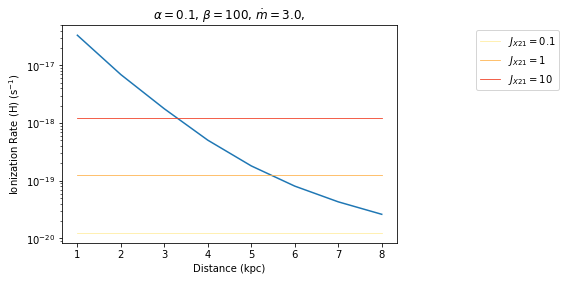

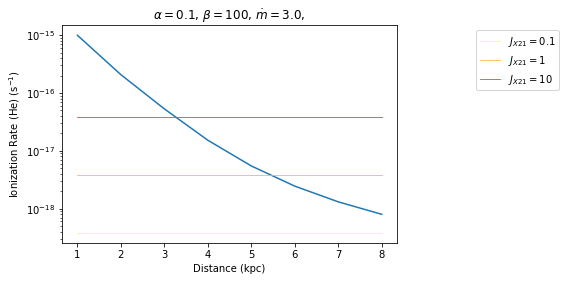

In [24]:
ip_H, ip_He = np.array([]), np.array([])
for i in Dat2:
    ip_H = np.append(Ion_p(H, He, H, i), ip_H)
    ip_He = np.append(Ion_p(H, He, He, i), ip_He)

plt.plot(np.arange(8)+1, ip_H)

ip_model_H = Ion_p(H, He, H)
plt.plot([1,8], [ip_model_H/10, ip_model_H/10], label = '$J_{X21}=0.1$', color = '#ffeda0', lw = 0.8)
plt.plot([1,8], [ip_model_H, ip_model_H], label = '$J_{X21}=1$', color = '#feb24c', lw = 0.8)
plt.plot([1,8], [ip_model_H*10, ip_model_H*10], label = '$J_{X21}=10$', color = '#f03b20', lw = 0.8)
plt.yscale('log')
plt.xlabel('Distance (kpc)')
plt.ylabel('Ionization Rate (H) (s$^{-1}$)')
plt.legend(bbox_to_anchor=(1.5,1))
plt.title(Dat2[0].title(distance = False, alpha = True, beta = True, mdot = True))
plt.show()

plt.plot(np.arange(8)+1, ip_He)

ip_model_He = Ion_p(H, He, He)
plt.plot([1,8], [ip_model_He/10, ip_model_He/10], label = '$J_{X21}=0.1$', color = '#ffeda0', lw = 0.8)
plt.plot([1,8], [ip_model_He, ip_model_He], label = '$J_{X21}=1$', color = '#feb24c', lw = 0.8)
plt.plot([1,8], [ip_model_He*10, ip_model_He*10], label = '$J_{X21}=10$', color = '#f03b20', lw = 0.8)
plt.yscale('log')
plt.xlabel('Distance (kpc)')
plt.ylabel('Ionization Rate (He) (s$^{-1}$)')
plt.legend(bbox_to_anchor=(1.5,1))
plt.title(Dat2[0].title(distance = False, alpha = True, beta = True, mdot = True))
plt.show()

### Plot $F_\nu-\nu$
- $\alpha=0.1, \beta=100, \dot m=3$
- Blue line is a standard model which obeys a power law
- Orange lines are fluxes in different distances from the SMBH
- Each dash line is the flux which have gone through the absorption both in galactic disk and in the molecular cloud

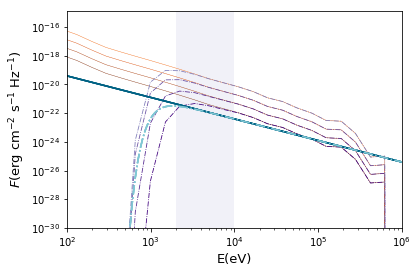

In [25]:
c = 0
for i in Dat:
    draw_Fnu(i, col1[c], col2[c], col3[c], absorb = False)
    draw_Fnu_model()
    c += 1
#plt.legend(bbox_to_anchor=(1.5,1))
plt.hist([2000, 10000], bins = 1, color = '#bcbddc', alpha = 0.2)
plt.show()

### Plot $\nu F_\nu-\nu$

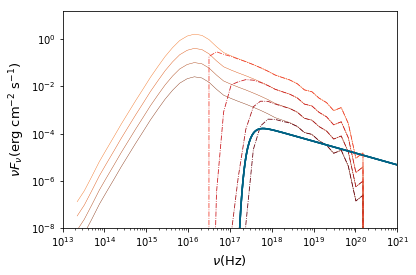

In [26]:
c = 0
for i in Dat:
    draw_nuF(i, col1[c], col2[c])
    draw_nuF_model()
    c += 1
#plt.legend(bbox_to_anchor=(1.5,1))
#plt.savefig('1.eps')
plt.show()

### Plot $\nu L_\nu-\nu$

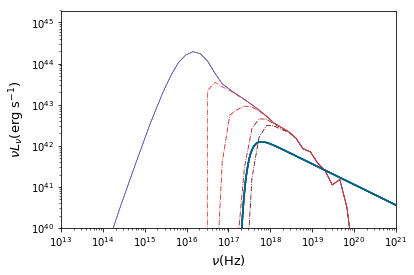

In [27]:
c = 0
for i in Dat:
    draw_nuL(i, col3[c], col2[c])
    draw_nuL_model()
    c += 1
#plt.legend(bbox_to_anchor=(1.5,1))
plt.show()

************************
alpha =  0.1
beta =  100
mdot =  0.5
************************
distance = 8.0 kpc

Total Flux:
0.0007779452167401866
0.0005347106263532685

Ionization Rate:
H -19.809300726775337 -17.094185110882215
He -18.326043607235846 -17.17030491207564

****************************
************************
alpha =  0.1
beta =  100
mdot =  0.5
************************
distance = 4.0 kpc

Total Flux:
0.0031117808669607464
0.0026982340772772995

Ionization Rate:
H -18.600119252104292 -15.887996073744995
He -17.120850295247976 -15.964190760806188

****************************
************************
alpha =  0.1
beta =  100
mdot =  0.5
************************
distance = 2.0 kpc

Total Flux:
0.012447123467842986
0.012259939171581417

Ionization Rate:
H -17.52004503853811 -14.810558712393524
He -16.044297957839987 -14.886819826612811

****************************
************************
alpha =  0.1
beta =  100
mdot =  0.5
************************
distance = 1.0 kpc

Total Flu

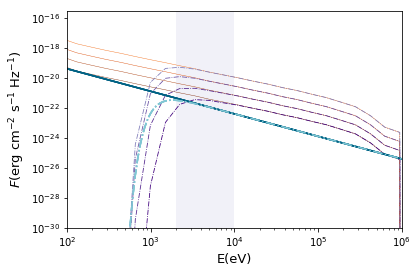

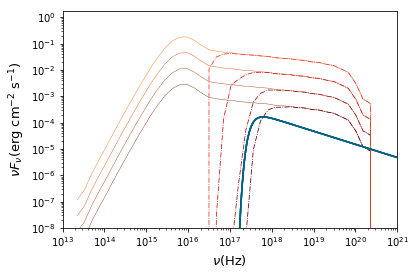

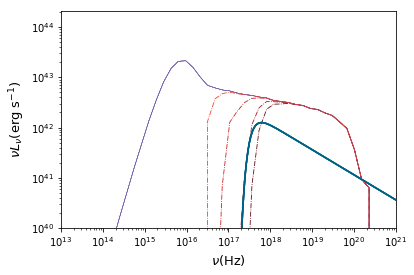

In [28]:
dic = {'alpha':0.1, 'beta':100, 'mdot':0.5}
Dat = compare(distance, dic)
for i in Dat:
    i.intro()
    print('distance =', i.distance_kpc, 'kpc')
    print('\nTotal Flux:')
    print(inte(i.nu, i.Fnu, lower = 2000*1.6021773e-12/h, upper = 10000*1.6021773e-12/h))
    print(inte(i.nu, i.Fnu_abs, lower = 2000*1.6021773e-12/h, upper = 10000*1.6021773e-12/h))
    print('\nIonization Rate:')
    test(H, He, i)
    print('****************************')
    
print('Standard ionization rate (JX21=0.1) ')
E = np.linspace(1.3e2, 6e8)
print('Total Flux:')
print(quad(lambda epsilon:J21*1e-21*np.power(epsilon/1000.0,-1.5)*4*np.pi/h_eV, 2000, 10000)[0])
print(quad(lambda epsilon:J21*1e-21*np.power(epsilon/1000.0,-1.5)*np.exp(-Tau(epsilon, H, He))*4*np.pi/h_eV, 2000, 10000)[0])
print('\nIonization Rate:')
test(H, He)

c = 0
for i in Dat:
    draw_Fnu(i, col1[c], col2[c], col3[c], absorb = False)
    draw_Fnu_model()
    c += 1
#plt.legend(bbox_to_anchor=(1.5,1))
plt.hist([2000, 10000], bins = 1, color = '#bcbddc', alpha = 0.2)
plt.savefig('Fnu-nu.eps')
plt.show()

c = 0
for i in Dat:
    draw_nuF(i, col1[c], col2[c])
    draw_nuF_model()
    c += 1
#plt.legend(bbox_to_anchor=(1.5,1))
plt.savefig('nuF-nu.eps')
plt.show()

c = 0
for i in Dat:
    draw_nuL(i, col3[c], col2[c])
    draw_nuL_model()
    c += 1
#plt.legend(bbox_to_anchor=(1.5,1))
plt.savefig('nuL-nu.eps')
plt.show()

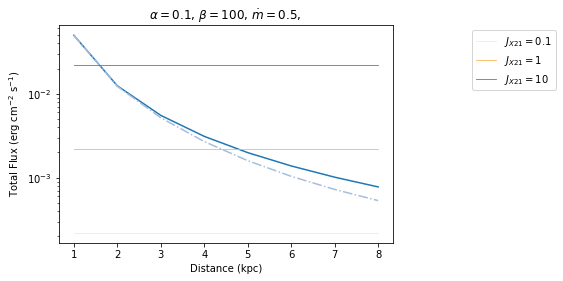

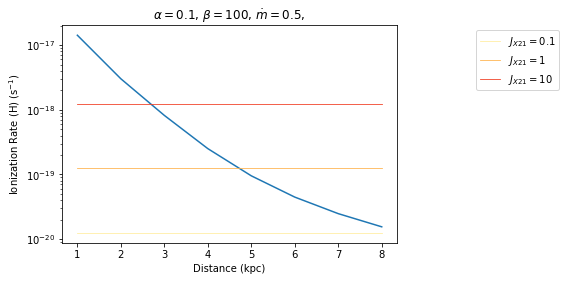

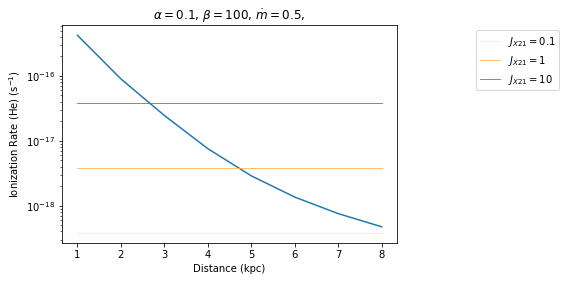

In [29]:
Dat2 = compare(np.arange(8)+1, dic)

ip, ip_abs = np.array([]), np.array([])
for i in Dat2:
    ip = np.append(inte(i.nu, i.Fnu, lower = 2000*1.6021773e-12/h, upper = 10000*1.6021773e-12/h), ip)
    ip_abs = np.append(inte(i.nu, i.Fnu_abs, lower = 2000*1.6021773e-12/h, upper = 10000*1.6021773e-12/h), ip_abs)
plt.plot(np.arange(8)+1, ip)
plt.plot(np.arange(8)+1, ip_abs, '-.', color = '#a6bddb')
ip_model = quad(lambda epsilon:J21*1e-21*np.power(epsilon/1000.0,-1.5)*np.exp(-Tau(epsilon, H, He))*4*np.pi/h_eV, 2000, 10000)[0]
plt.plot([1,8], [ip_model, ip_model], label = '$J_{X21}=0.1$', color = '#ffeda0', lw = 0.8)
plt.plot([1,8], [ip_model*10, ip_model*10], label = '$J_{X21}=1$', color = '#feb24c', lw = 0.8)
plt.plot([1,8], [ip_model*100, ip_model*100], label = '$J_{X21}=10$', color = '#f03b20', lw = 0.8)
plt.yscale('log')
plt.xlabel('Distance (kpc)')
plt.ylabel('Total Flux (erg cm$^{-2}$ s$^{-1}$)')
plt.legend(bbox_to_anchor=(1.5,1))
plt.title(Dat2[0].title(distance = False, alpha = True, beta = True, mdot = True))
plt.savefig('total_flux.eps')
plt.show()

ip_H, ip_He = np.array([]), np.array([])
for i in Dat2:
    ip_H = np.append(Ion_p(H, He, H, i), ip_H)
    ip_He = np.append(Ion_p(H, He, He, i), ip_He)

plt.plot(np.arange(8)+1, ip_H)

ip_model_H = Ion_p(H, He, H)
plt.plot([1,8], [ip_model_H/10, ip_model_H/10], label = '$J_{X21}=0.1$', color = '#ffeda0', lw = 0.8)
plt.plot([1,8], [ip_model_H, ip_model_H], label = '$J_{X21}=1$', color = '#feb24c', lw = 0.8)
plt.plot([1,8], [ip_model_H*10, ip_model_H*10], label = '$J_{X21}=10$', color = '#f03b20', lw = 0.8)
plt.yscale('log')
plt.xlabel('Distance (kpc)')
plt.ylabel('Ionization Rate (H) (s$^{-1}$)')
plt.legend(bbox_to_anchor=(1.5,1))
plt.title(Dat2[0].title(distance = False, alpha = True, beta = True, mdot = True))
plt.savefig('ionization_H.eps')
plt.show()

plt.plot(np.arange(8)+1, ip_He)

ip_model_He = Ion_p(H, He, He)
plt.plot([1,8], [ip_model_He/10, ip_model_He/10], label = '$J_{X21}=0.1$', color = '#ffeda0', lw = 0.8)
plt.plot([1,8], [ip_model_He, ip_model_He], label = '$J_{X21}=1$', color = '#feb24c', lw = 0.8)
plt.plot([1,8], [ip_model_He*10, ip_model_He*10], label = '$J_{X21}=10$', color = '#f03b20', lw = 0.8)
plt.yscale('log')
plt.xlabel('Distance (kpc)')
plt.ylabel('Ionization Rate (He) (s$^{-1}$)')
plt.legend(bbox_to_anchor=(1.5,1))
plt.title(Dat2[0].title(distance = False, alpha = True, beta = True, mdot = True))
plt.savefig('ionization_He.eps')
plt.show()

## Add calculated ionization rates to KROME's datafile 

### Column density vs. Ionization rate

In [37]:
dataH = np.loadtxt('ratexH.dat')
dataHe = np.loadtxt('ratexHe.dat')
dataH[:,1] += dataH[:,0] 
dataH = 10**dataH
dataHe[:,1] += dataHe[:,0] 
dataHe = 10**dataHe

### Column density vs. Number density
$$N^i=n^i\sqrt{\frac{\pi kT}{G\rho\mu m_H}}$$
Thus
$$
\frac{N_H}{N_{He}}=\frac{n_H}{n_{He}}\equiv\chi
$$
Furthurmore
$$
\rho\mu m_H=\frac{(m_Hn_H+m_{He}n_{He})^2}{n_H+n_{He}}=n_H\frac{(m_H\chi+m_{He})^2}{\chi+1}
$$

In [35]:
def num2col(nH, nHe):
    chi = nH/nHe
    A = np.sqrt(np.pi*k*T/G)
    B = np.sqrt((mH*chi+mHe)**2/(chi+1)*nH)
    return(nH*A/B, nHe*A/B)
def col2num(NH, NHe):
    chi = NH/NHe
    C = np.sqrt(np.pi*k*T/G/(mH*chi+mHe)**2*(chi+1))
    nH = (NH/C)**2
    nHe = nH/chi
    return(nH, nHe)

In [38]:
dataH[:,0], dataH[:,1] = col2num(dataH[:,0], dataH[:,1])
dataHe[:,0], dataHe[:,1] = col2num(dataHe[:,0], dataHe[:,1])
daH, daHe = dataH.copy(), dataHe.copy()

In [62]:
ion = np.array([])
for nH, nHe in daH[:,0:2]:
    ion = np.append(ion, Ion_p(H, He, H, None, nH, nHe))
for i in range(len(ion)):
    print(np.log10(ion[i]), np.log10(daH[:,-1][i]))

-18.8189764698801 -18.818976
-18.818976462451943 -18.818976
-18.81897645648546 -18.818976
-18.81897645174478 -18.818976
-18.818976448042505 -18.818976
-18.818976445232277 -18.818976
-18.818976443203006 -18.818976
-18.818976441874465 -18.818976
-18.818976441194142 -18.818976
-18.818976441135142 -18.818976
-18.81897644169513 -18.818976
-18.818976442896247 -18.818976
-18.81897644478597 -18.818976
-18.81897644743901 -18.818976
-18.818976450960236 -18.818976
-18.81897645548885 -18.818976
-18.818976461203874 -18.818976
-18.818976468331236 -18.818976
-18.81897647715268 -18.818976
-18.818976488016922 -18.818976
-18.81897650135346 -18.818976
-18.818976517689496 -18.818976
-18.818976537670828 -18.818976
-18.818976562087318 -18.818976
-18.818976591904153 -18.818976
-18.818976628300103 -18.818976
-18.818976672713912 -18.818976
-18.818976726901315 -18.818976
-18.818976793004456 -18.818976
-18.818976873636394 -18.818976
-18.818976523706446 -18.818977
-18.818976507273746 -18.818977
-18.81897649407458

In [60]:
ion = np.array([])
Dat[1].intro()
print(Dat[1].distance_kpc)
for nH, nHe in daH[:,0:2]:
    ion = np.append(ion, Ion_p(H, He, H, Dat[1], nH, nHe))
for i in range(len(ion)):
    print(np.log10(daH[:,-1][i]), np.log10(ion[i]))

************************
alpha =  0.1
beta =  100
mdot =  0.5
************************
4.0
-18.818976 -18.210667232093478
-18.818976 -18.21066717437357
-18.818976 -18.21066712804207
-18.818976 -18.210667091267435
-18.818976 -18.21066706259591
-18.818976 -18.210667040894094
-18.818976 -18.210667025304076
-18.818976 -18.210667015209562
-18.818976 -18.210667010211505
-18.818976 -18.210667010112335
-18.818976 -18.21066701490812
-18.818976 -18.21066702478845
-18.818976 -18.210667040143893
-18.818976 -18.2106670615815
-18.818976 -18.2106670899487
-18.818976 -18.210667126366886
-18.818976 -18.210667172275713
-18.818976 -18.210667229490053
-18.818976 -18.21066730027158
-18.818976 -18.21066738741829
-18.818976 -18.21066749437539
-18.818976 -18.210667625370913
-18.818976 -18.210667785583343
-18.818976 -18.21066798134584
-18.818976 -18.21066822039684
-18.818976 -18.210668512186757
-18.818976 -18.21066886824999
-18.818976 -18.210669302661877
-18.818976 -18.2106698325952
-18.818976 -18.210670478997